In [19]:
import numpy as np

import matplotlib.pyplot as plt

In [20]:
import sed

In [35]:
from importlib import reload
reload(sed)


<module 'sed' from '/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/sed.py'>

In [36]:
model, fermi, iact = sed.read_seds()

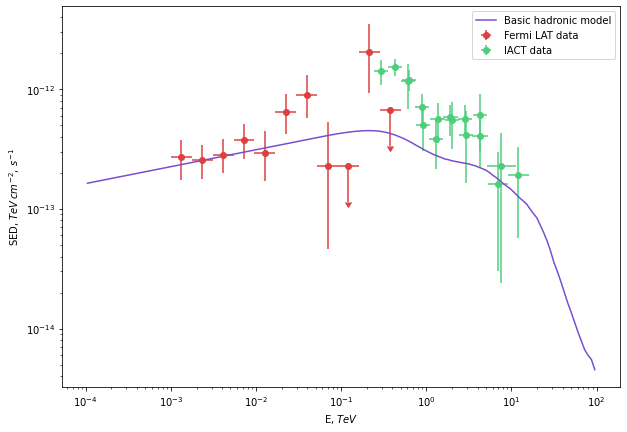

In [37]:
fig, ax = plt.subplots(figsize=(10, 7))

fermi.plot(ax)
model.plot(ax)
iact.plot(ax)

ax.legend()
plt.show()

## Как влияет сдвиг энергетической шкалы на SED?

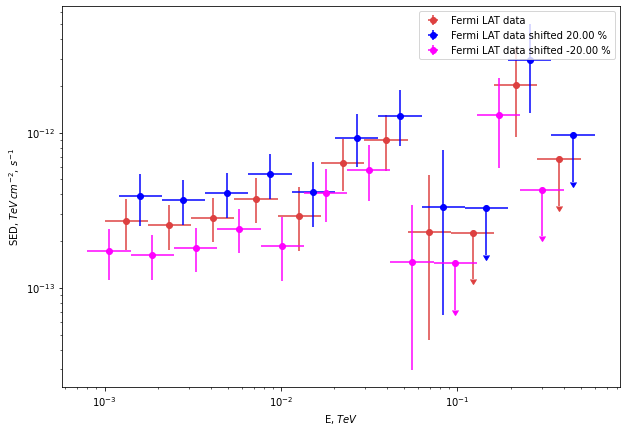

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))

fermi.plot(ax)
fermi.with_E_factor(1.2, color='blue').plot(ax)
fermi.with_E_factor(0.8, color='magenta').plot(ax)

ax.legend()
plt.show()

### Систематическая погрешность определения энергии Fermi

См. https://fermi.gsfc.nasa.gov/ssc/data/analysis/LAT_caveats.html, раздел Other systematic effects and uncertainties, а также Ackermann, M., Ajello, M., Allafort, A., et al. 2012, Astroparticle Physics, 35 (Elsevier BV), 346, http://dx.doi.org/10.1016/j.astropartphys.2011.10.007:

```
The absolute energy scale for the LAT is determined with an uncertainty of +2% -5%
```

Положим неопределённость шкалы энергии Fermi равной $5$%

In [25]:
fermi.set_systematic_energy_uncertainty(0.05)

### Систематическая погрешность определения энергии IACT

См., например, https://fermi.gsfc.nasa.gov/science/mtgs/symposia/2007/posters/P19_02.pdf.

Для энергий $> 100$ GeV положим неопределённость IACT равной $35$%.

In [26]:
iact.set_systematic_energy_uncertainty(0.35)

# MCMC

Пусть

1. $k$ - свободный параметр нормализации модельного спектра
2. $\delta_{Fermi}$ - множитель, описывающий систематическую погрешность шкалы энергии Fermi -- распределён нормально с установленной выше $\sigma$
3. $\delta_{IACT}$ - аналогично для IACT

Определим $\theta = (k, \delta_{Fermi}, \delta_{IACT})$

In [27]:
from numba import njit

fermi_logprior = fermi.get_logprior()
fermi_loglike = fermi.get_loglikelihood(model)
iact_logprior = iact.get_logprior()
iact_loglike = iact.get_loglikelihood(model)

@njit
def logposterior(theta):
    k, d_fermi, d_iact = theta
    logprior = fermi_logprior(d_fermi) + iact_logprior(d_iact)
    return logprior if logprior == - np.inf else logprior + fermi_loglike(k, d_fermi) + iact_loglike(k, d_iact)


In [28]:
import emcee

n_walkers = 64
n_dim = 3
sampler = emcee.EnsembleSampler(n_walkers, n_dim, logposterior)

In [29]:
theta_estimation = np.array([1, 1, 1], dtype='float')
theta_starting_point_log_sigmas = [0.5, 0.1, 0.5]

starting_points = np.tile(theta_estimation, (n_walkers, 1))
for i, sigma in enumerate(theta_starting_point_log_sigmas):
    starting_points[:, i] = np.exp(np.random.normal(loc=0, scale=np.log(1 + sigma), size=(n_walkers,)))

In [30]:
sampler.run_mcmc(starting_points, 50000)

print('done')

/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/kbhmenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
done


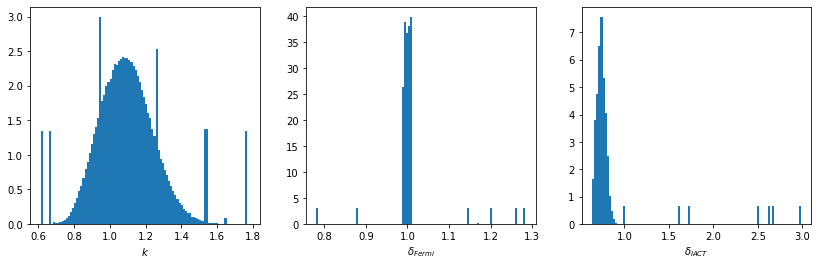

In [31]:
sample = sampler.get_chain(flat=True, thin=5, discard=1000)

k_sample = sample[:, 0]
delta_fermi_sample = sample[:, 1]
delta_iact_sample = sample[:, 2]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

ax1.set_xlabel('$k$')
ax1.hist(k_sample, bins=100, density=True)

ax2.set_xlabel('$\\delta_{Fermi}$')
ax2.hist(delta_fermi_sample, bins=100, density=True)

ax3.set_xlabel('$\\delta_{IACT}$')
ax3.hist(delta_iact_sample, bins=100, density=True)

plt.show()

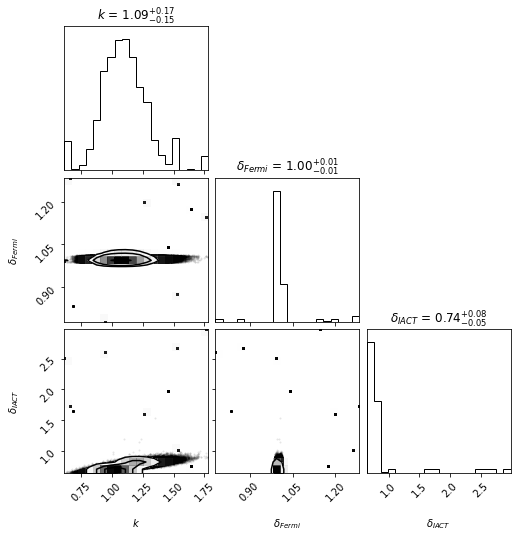

In [32]:
import corner

figure = corner.corner(sample, labels=["$k$", "$\\delta_{Fermi}$", "$\\delta_{IACT}$"], show_titles=True)

In [33]:
k_est = np.mean(k_sample)
delta_fermi_est = np.mean(delta_fermi_sample)
delta_iact_est = np.mean(delta_iact_sample)

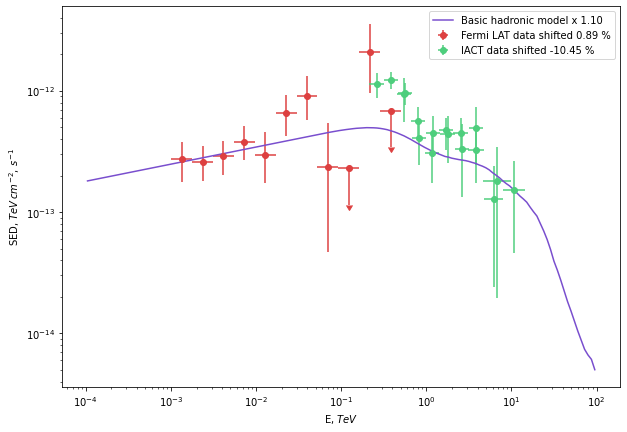

In [38]:
fig, ax = plt.subplots(figsize=(10, 7))

fermi.with_E_factor(delta_fermi_est).plot(ax)
iact.with_E_factor(delta_iact_est).plot(ax)
model.with_normalization(k_est).plot(ax)

ax.legend()
plt.show()